In [225]:
%load_ext autoreload
%autoreload 2

%pylab inline
import sys, fiona
sys.path.append("../")
sys.path.insert(0,"/home/luca/Code/topojson.git/")
import mappy as mpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'copy', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# interesting link for checking overlaps
https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

In [226]:
infile = "output-map-data.gpkg"
layer_name  = "polygons_labelled"
column_name="unit_name"

# infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01.gpkg"
# layer_name= "subregion_fixed"
# column_name="Unit_Code"

In [227]:
import geopandas as gpd

In [228]:
fiona.listlayers(infile)

['intersections', 'polygons', 'polygons_labelled']

In [229]:
polygons = gpd.read_file(infile, layer=layer_name).explode()
if np.any(polygons.geometry.values == None):
    log.info("dropping null entries")
    startmap = startmap[polygons.geometry.values != None] # remove null geometries 
    
polygons = polygons.drop_duplicates("geometry")

# polygons = polygons.dissolve(by=column_name, aggfunc = 'first', as_index=False).explode()



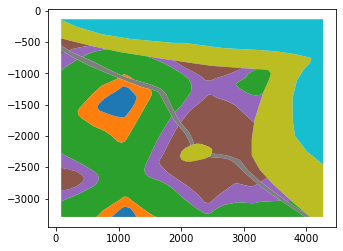

In [230]:
polygons.plot(column=column_name)

In [231]:
polygons.to_file("dissolved.gpkg", layer="dissolved", driver="GPKG")

In [232]:
from shapely.ops import polylabel


labels = []
for pol in polygons.geometry:
    labels.append(polylabel(pol, tolerance=0.1))

In [233]:
for pol in polygons.geometry:
    if not pol.is_valid:
        print("not valid")

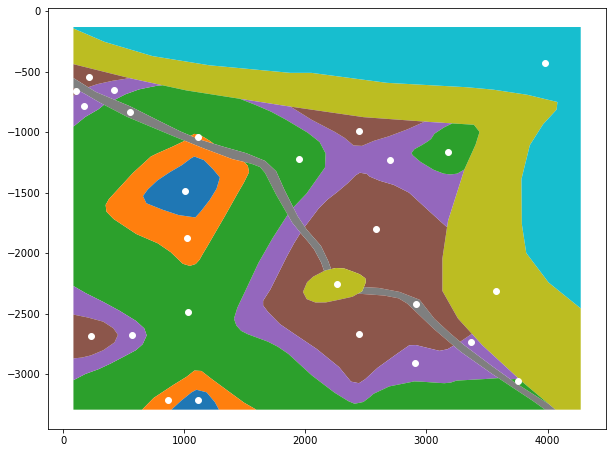

In [406]:
figure(figsize=(10,10))
aspd = gpd.GeoDataFrame(geometry=labels)
polygons.plot(column=column_name,ax=gca())
aspd.plot(ax=gca(), color="white", markersize=35)
aspd.to_file("test.gpkg", driver="GPKG", layer="points")

In [235]:
import topojson 

tj = topojson.Topology(polygons, prequantize=1e4)
# tj = tj.toposimplify(1).topoquantize(1e6)

/home/luca/Code/topojson.git/topojson/ops.py:528: ShapelyDeprecationWarning: Setting the 'coords' to mutate a Geometry in place is deprecated, and will not be possible any more in Shapely 2.0
  ls.coords = ls_xy[bool_slice]


In [236]:
asgdf =  tj.to_gdf()

In [237]:
# asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

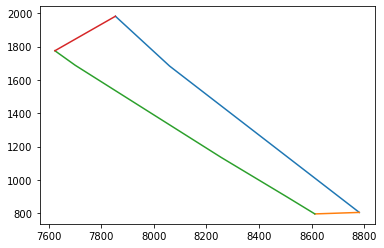

In [238]:

arc_ids = tj.output["objects"]["data"]["geometries"][4]["arcs"][0]


for id in arc_ids:
    if id < 0:
        id = -id-1
    pts = tj.output["arcs"][np.abs(id)]
    pts = np.cumsum(np.array(pts), axis=0)
    plot(*pts.T)

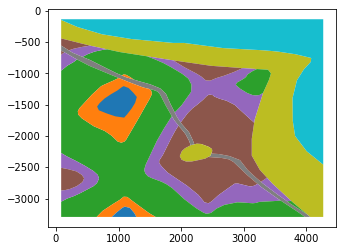

In [239]:
tj.to_gdf().plot(column=column_name)

In [240]:
import topojson, copy
from topojson.ops import np_array_from_arcs


def extract_numpy_arcs(topology):
    s = np.array(topology.output["transform"]["scale"])
    t = np.array(topology.output["transform"]["translate"])
    top = topology._resolve_coords(topology.output)
    np_arcs = np_array_from_arcs(top["arcs"])
    out = topojson.ops.dequantize(np_arcs, s, t)

    out = [o[~np.isnan(o).any(axis=1)] for o in out]
    
    return out

out = extract_numpy_arcs(tj)

In [241]:
import attr
@attr.attrs(eq=False)
class Arc:
    points = attr.ib(repr=False)
    id = attr.ib()
    separating_polygons = attr.ib(factory=list, repr=False)
    
@attr.attrs
class Polygon:
    arcs = attr.ib()
    
arcs = [Arc(points=np.array(arc_pts), id=id) for id, arc_pts in enumerate(tj.output["arcs"])]
# id_to_arcs

In [242]:
pols = []
# all_arcs = []
for pol in tj.output["objects"]["data"]["geometries"]:
    newarcs = []
    for li in pol["arcs"]:
        olist = []
        for arc in li:
#             arcid = list(id_to_arcs.keys())[np.abs(arc)]
            if arc < 0:
                arc = -arc-1
            myarc = arcs[arc]
            olist.append(myarc)
        newarcs.append(olist)
        
    mypol = Polygon(newarcs)
    pols.append(mypol)
    
    for ll in newarcs:
        for narc in ll:
            if mypol not in narc.separating_polygons:
                narc.separating_polygons.append(mypol)

triple = []
# just checks            
for pol in pols:
    for l in pol.arcs:
        for arc in l:
            if len(arc.separating_polygons) > 2:
                print(f"more than 2 pols: {len(arc.separating_polygons)}")
                triple.append(arc)
            if len(arc.separating_polygons) == 1:
                pass

In [243]:
asgdf = tj.to_gdf()
geoms = asgdf.geometry
simple = gpd.GeoDataFrame(geometry=geoms)

In [244]:
asgdf.columns

Index(['geometry', 'id', 'unit_name'], dtype='object')

In [245]:
if "Id" in asgdf.columns:
    asgdf = asgdf.drop(columns="Id")
asgdf.to_file("test.gpkg",layer="test", driver="GPKG") # for some reason Id column breaks fiona

(-126.83301456275805,
 4483.832784916167,
 -3452.1244527784684,
 25.842347143428242)

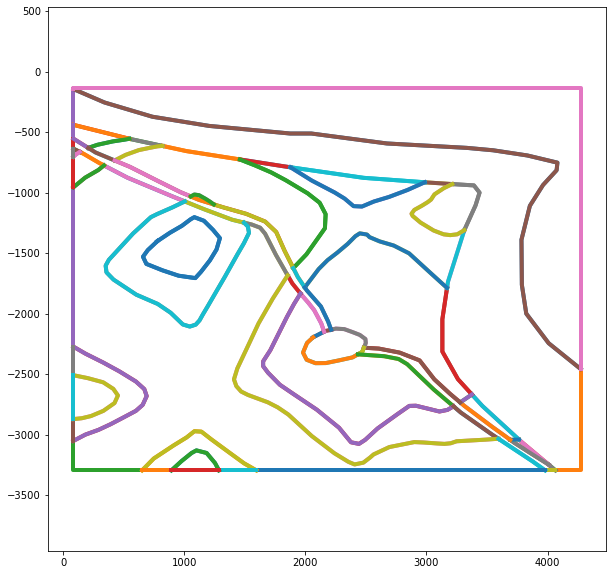

In [417]:
figure(figsize=(10,10))

s = np.array(tj.output["transform"]["scale"])
t = np.array(tj.output["transform"]["translate"])

for id, pol in enumerate(pols):
# pol = pols[6]
#     figure()
    for l in pol.arcs:

        for arc in l:
            aa = np.cumsum(arc.points, axis=0) * s + t
            plot(*aa.T, linewidth=4)
#             text(*aa[0], str(arc.id))

axis('equal')

In [247]:
# tt = list(id_to_arcs.values())[0]
# for idpol, pol in enumerate(tt.separating_polygons):
#     for l in pol.arcs:
#         for arc in l:
#             aa = arc.points
#             plot(*np.cumsum(aa, axis=0).T)
#             text(*aa[0], str(idpol))

In [248]:
# tt = triple[1]
# for idpol, pol in enumerate(tt.separating_polygons):
#     for l in pol.arcs:
#         for arc in l:
#             aa = arc.points
#             plot(*np.cumsum(aa, axis=0).T)
#             text(*aa[0], str(idpol))

In [249]:
@attr.attrs(frozen=True)
class Node():
    x = attr.ib()
    y = attr.ib()
    
    def as_np(self):
        return np.array([self.x,self.y])
# hash(Node(1,2))

In [250]:
hash(Node(1,2))

98568750825008149

In [251]:
import networkx
g = networkx.Graph()
nodes = []

for arc in arcs:
    start = Node(*np.cumsum(arc.points, axis=0)[0])
    end = Node(*np.cumsum(arc.points, axis=0)[-1])
    
#     if start == end:
#         print("equals")
#         print(f"arc {np.cumsum(arc.points, axis=0)}")
        
    g.add_edge(start, end, arc=arc)
    
    
    

In [252]:
# networkx.get_edge_attributes(g, "arc")

In [253]:
pos= {}
for node in g.nodes:
    mypos = [node.x, node.y] 
    pos[node] = mypos
    
# pos

In [254]:
# a = np.array([12,3])
# networkx.draw?

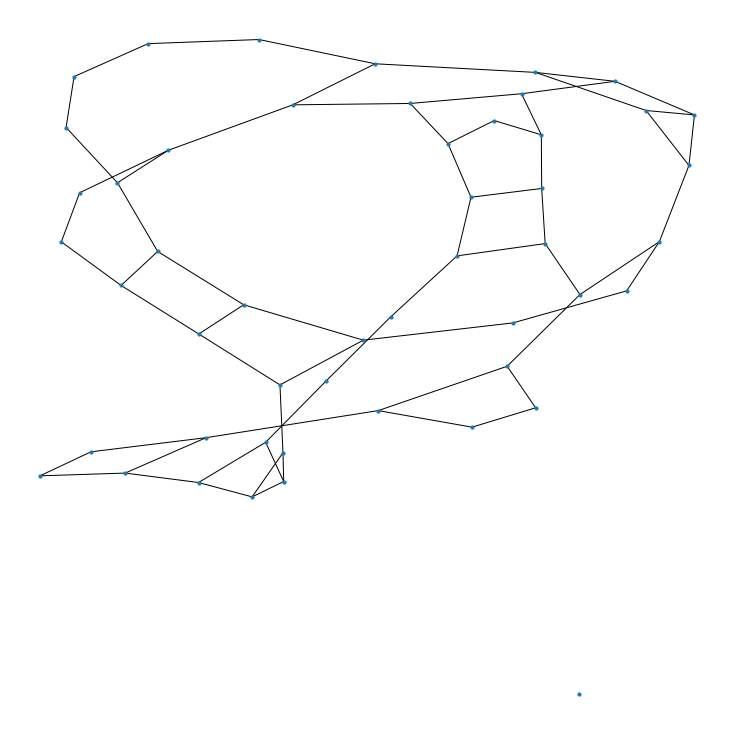

In [255]:
figure(figsize=(10,10))
networkx.draw(g, node_size=10)

In [256]:
azimuth(c, p2)

90.0

In [257]:
c = np.array([0,0])

p1 = np.array([0,1])
p2 = np.array([1,0])
p3 = np.array([0,-1])

azimuth(c, p1) - azimuth(c , p3)

-180.0

In [258]:
from itertools import combinations

attrs = networkx.get_edge_attributes(g, "arc")

def get_edge_point(edge, g, center_node):
    arc1 = g.get_edge_data(*edge)["arc"]
    arc_1_pts = np.cumsum(arc1.points, axis=0)
    
    if np.array_equal(arc_1_pts[0] ,center_node.as_np()):
        arc1_pt = arc_1_pts[1]
    elif np.array_equal(arc_1_pts[-1] ,center_node.as_np()):
        arc1_pt = arc_1_pts[-2]
    else:
        print("no point in common")
        
    return arc1_pt


def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def select_best_couple(edges, g, node):
    angles = []
    possible_edges = []
    for edge1, edge2 in combinations(edges,r=2):
        arc1_pt = get_edge_point(edge1, g, node)
        arc2_pt = get_edge_point(edge2, g, node)
        
        angle = azimuth(arc1_pt, node.as_np()) - azimuth(arc2_pt, node.as_np())
        angle = np.abs(angle)
        if angle> 180:
            angle = 360-angle
        angle = 180-angle
#         print(angle)
        angles.append(angle)
        possible_edges.append([edge1, edge2])
        
    minangleid = np.argmin(angles)
    selected_angle = angles[minangleid]
    selected_edges =  possible_edges[minangleid]
    return selected_edges
    
couples = []
for node in g.nodes:
    edges = list(g.edges(nbunch=node))
    if len(edges) > 3:
        print(f"larger than 3: {len(edges)}")
    if len(edges) == 1:
        print("1 edge, nothing to do")
        continue
    
    while len(edges) > 1:
        ed1, ed2 = select_best_couple(edges, g, node)
        couples.append([ed1, ed2])
        edges.remove(ed1)
        edges.remove(ed2)
    
        
   
    
        
        
     
        
        
    

1 edge, nothing to do


In [259]:
id_to_edge = {}
edge_to_id = {}
for i, edge in enumerate(g.edges):
    id_to_edge[i] = edge
    edge_to_id[edge] = i

In [260]:
test = couple[1]
test

(Node(x=6861, y=9681), Node(x=6848, y=9660))

In [261]:
test2 = list(edge_to_id.keys())[3]
test2

(Node(x=9501, y=0), Node(x=9297, y=0))

In [262]:
test in edge_to_id.keys()

False

In [263]:
edge_to_id.keys()

dict_keys([(Node(x=9999, y=2647), Node(x=9501, y=0)), (Node(x=9999, y=2647), Node(x=0, y=9962)), (Node(x=9501, y=0), Node(x=9367, y=150)), (Node(x=9501, y=0), Node(x=9297, y=0)), (Node(x=0, y=9028), Node(x=0, y=9962)), (Node(x=0, y=9028), Node(x=1103, y=8664)), (Node(x=0, y=9028), Node(x=0, y=8666)), (Node(x=9367, y=150), Node(x=8781, y=805)), (Node(x=9367, y=150), Node(x=8612, y=796)), (Node(x=9297, y=0), Node(x=8377, y=825)), (Node(x=9297, y=0), Node(x=3604, y=0)), (Node(x=8781, y=805), Node(x=7854, y=1982)), (Node(x=8781, y=805), Node(x=8612, y=796)), (Node(x=8612, y=796), Node(x=7624, y=1775)), (Node(x=7854, y=1982), Node(x=7364, y=4767)), (Node(x=7854, y=1982), Node(x=7624, y=1775)), (Node(x=7624, y=1775), Node(x=5725, y=3204)), (Node(x=7364, y=4767), Node(x=7705, y=6276)), (Node(x=7364, y=4767), Node(x=4560, y=4780)), (Node(x=5725, y=3204), Node(x=5079, y=3674)), (Node(x=5725, y=3204), Node(x=5608, y=3031)), (Node(x=7705, y=6276), Node(x=7467, y=7480)), (Node(x=4560, y=4780), Nod

In [264]:
def invert_edge(aa):
    return (aa[1], aa[0])

In [265]:
ge = networkx.Graph()
for couple in couples:
#     print("done")
    try:
        id1 = edge_to_id[couple[0]]
    except:
        id1 = edge_to_id[invert_edge(couple[0])]
#         print(f"seems edge {couple[0]} not in dict")
    
    try:
        id2 = edge_to_id[couple[1]]
    except:
        id2 = edge_to_id[invert_edge(couple[1])]
    
    
    ge.add_edge(id1, id2)

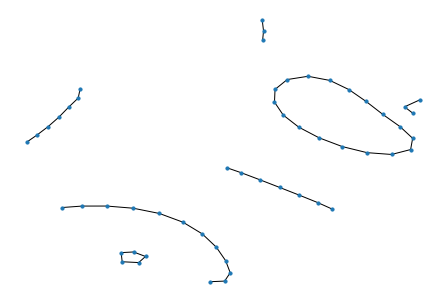

In [277]:
networkx.draw(ge, node_size=10)

In [281]:
edges = []
ccs = list(networkx.connected_components(ge))

for cc in ccs:
    edge_set = []
    for eid in cc:
        edge = id_to_edge[eid]
        edge_set.append(edge)
    edges.append(edge_set)

In [399]:
data = [["B", "A"], ["C", "B"], ["D", "C"], ["E", "D"]]
data

def domino_sort(data):
    ordered = []
    prev = data[0]

    if prev[1] not in data[1]:
        prev = [prev[1], prev[0]]

    ordered.append(prev)

    for i, item in enumerate(data[1:]):
        if item[0] != prev[1]:
            item = [item[1], item[0]]

        ordered.append(item)
        prev = item
    return ordered
ordered

[['A', 'B'], ['B', 'C'], ['C', 'D'], ['D', 'E']]

In [400]:
domino_sort(edges[0])

[[Node(x=9501, y=0), Node(x=9999, y=2647)],
 (Node(x=9999, y=2647), Node(x=0, y=9962)),
 [Node(x=1932, y=0), Node(x=2868, y=0)],
 [Node(x=9297, y=0), Node(x=9501, y=0)],
 [Node(x=0, y=9962), Node(x=0, y=9028)],
 [Node(x=0, y=8405), Node(x=0, y=8666)],
 [Node(x=0, y=8666), Node(x=0, y=9028)],
 [Node(x=0, y=2485), Node(x=0, y=1339)],
 [Node(x=3604, y=0), Node(x=9297, y=0)],
 [Node(x=0, y=8197), Node(x=0, y=8405)],
 [Node(x=2868, y=0), Node(x=3604, y=0)],
 [Node(x=0, y=770), Node(x=1354, y=0)],
 (Node(x=1354, y=0), Node(x=1932, y=0)),
 [Node(x=0, y=1339), Node(x=0, y=770)],
 [Node(x=0, y=7397), Node(x=0, y=3231)],
 (Node(x=0, y=3231), Node(x=0, y=2485)),
 [Node(x=0, y=8197), Node(x=0, y=7397)]]

[ 0  1  4  6 36 46 60 57 58 65 56 53 54 64 52 10  3]
origi (Node(x=9999, y=2647), Node(x=9501, y=0))
flip
(Node(x=9501, y=0), Node(x=9999, y=2647))
origi (Node(x=9999, y=2647), Node(x=0, y=9962))
flip
(Node(x=0, y=9962), Node(x=9999, y=2647))
origi (Node(x=0, y=9028), Node(x=0, y=9962))
flip
(Node(x=0, y=9962), Node(x=0, y=9028))
origi (Node(x=0, y=9028), Node(x=0, y=8666))
flip
(Node(x=0, y=8666), Node(x=0, y=9028))
origi (Node(x=0, y=8666), Node(x=0, y=8405))
flip
(Node(x=0, y=8405), Node(x=0, y=8666))
origi (Node(x=0, y=8405), Node(x=0, y=8197))
flip
(Node(x=0, y=8197), Node(x=0, y=8405))
origi (Node(x=0, y=7397), Node(x=0, y=8197))
flip
(Node(x=0, y=8197), Node(x=0, y=7397))
origi (Node(x=0, y=3231), Node(x=0, y=7397))
flip
(Node(x=0, y=7397), Node(x=0, y=3231))
origi (Node(x=0, y=3231), Node(x=0, y=2485))
flip
(Node(x=0, y=2485), Node(x=0, y=3231))
origi (Node(x=0, y=1339), Node(x=0, y=2485))
flip
(Node(x=0, y=2485), Node(x=0, y=1339))
origi (Node(x=0, y=770), Node(x=0, y=1339))
f

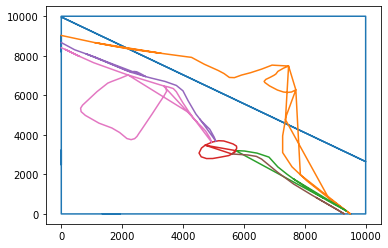

In [376]:
def assembly_line(g, sug, id_to_edge):
    leaves = []
    for node in subg.nodes():
        if subg.degree(node) == 1:
            leaves.append(node)


    if len(leaves) == 0:
        cycle = networkx.algorithms.find_cycle(subg)
        order = np.array(cycle)[:,0]
    else:
        order = np.array(networkx.algorithms.shortest_path(subg, leaves[0], leaves[1]))

    print(order)

    arcs = networkx.get_edge_attributes(g, "arc")

    line = []
    for i, id in enumerate(order):
        myedge = id_to_edge[id]
        try:
            next_id = order[i+1]
        except:
            next_id = None

        toflip = False    
        print(f"origi {myedge}")
        if next_id:
            next_edge = id_to_edge[next_id]

            if myedge[1] != next_edge[0] or myedge[1] != next_edge[1]:
                toflip = True

        else: #last edge
            prev_id = order[i-1]
            prev_edge = id_to_edge[prev_id]
            if myedge[0] != prev_edge[1] or myedge[0] != prev_edge[0]:
                toflip = True


        
        
        arc = arcs[myedge]
        if toflip:
            print("flip")
            myedge = (myedge[1], myedge[0])
            
        print(myedge)
        pts = np.cumsum(arc.points, 0)
        
        if not np.array_equal(myedge[0].as_np(), pts[0]):
            pts = np.flip(pts, axis=0)
            
#         node1, node2 = myedge
#         if toflip:
# #             print("flip")
#             pts = np.flip(pts, axis=0)
#         print(pts)
        

        line.append(pts)

    lines = np.row_stack(line)
    return lines


from shapely.geometry import LineString, LinearRing
for cc in ccs:
    subg = ge.subgraph(cc)
    lines = assembly_line(g, subg, id_to_edge)
    if np.array_equal(lines[0], lines[-1]):
        line =LinearRing(lines)
    else:
        line = LineString(lines)
    
    plot(*lines.T)

(Node(x=9999, y=2647), Node(x=9501, y=0))
flip
[[9501    0]
 [9999    0]
 [9999 2647]]
(Node(x=9999, y=2647), Node(x=0, y=9962))
flip
[[9999 2647]
 [9999 9999]
 [   0 9999]
 [   0 9962]]
(Node(x=0, y=9028), Node(x=0, y=9962))
flip
[[   0 9962]
 [   0 9028]]
(Node(x=0, y=9028), Node(x=0, y=8666))
flip
[[   0 9028]
 [   0 8666]]
(Node(x=0, y=8666), Node(x=0, y=8405))
flip
[[   0 8666]
 [   0 8405]]
(Node(x=0, y=8405), Node(x=0, y=8197))
flip
[[   0 8405]
 [   0 8197]]
(Node(x=0, y=7397), Node(x=0, y=8197))
flip
[[   0 8197]
 [   0 7397]]
(Node(x=0, y=3231), Node(x=0, y=7397))
flip
[[   0 7397]
 [   0 3231]]
(Node(x=0, y=3231), Node(x=0, y=2485))
flip
[[   0 3231]
 [   0 2485]]
(Node(x=0, y=1339), Node(x=0, y=2485))
flip
[[   0 2485]
 [   0 1339]]
(Node(x=0, y=770), Node(x=0, y=1339))
flip
[[   0 1339]
 [   0  770]]
(Node(x=1354, y=0), Node(x=0, y=770))
flip
[[   0  770]
 [   0    0]
 [1354    0]]
(Node(x=1354, y=0), Node(x=1932, y=0))
flip
[[1354    0]
 [1932    0]]
(Node(x=2868, y=0), N

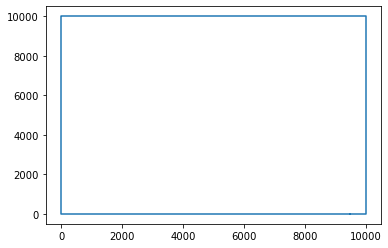

In [ ]:
figure(figsize=(20,20))
for pol in pols:
    for l in pol.arcs:
        for i, a in enumerate(l):
    #         print (arc.points)
            pts = np.cumsum(a.points, axis=0)
            if len(a.separating_polygons) > 2:
                text(*pts[0],str(i))
            plot(*pts.T)

In [ ]:
arc.separating_polygons

In [ ]:
@attr.attrs
class Line():
    arcs = attr.ib(factory=list)

for pol in pols:
    myarcs = []
    for l in pol.arcs:
        print("new")
        for arc in l:
            print(arc)
            
        
    

In [ ]:
from shapely.geometry import LineString
lines = [] 
for arc in out:
    lines.append(LineString(arc))

In [ ]:
asgpd = gpd.GeoDataFrame(geometry=lines)
asgpd.plot()

In [ ]:
asgpd.to_file("data.gpkg", driver="GPKG", layer="lines")